In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats
import powerlaw
from levy import fit_levy
import levy

%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/finance_M4/my_fx_data', header = None, usecols = [1], names = ['price'])
logR = np.log(my_data).diff()
logR.drop(logR.index[0], inplace = True)

In [4]:
ripple = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
ripple['Date']=pd.to_datetime(ripple['Date'])
ripple.set_index('Date', inplace = True)
close = np.flip(ripple['Close'], 0)
logRR = np.log(close).diff()
logRR.drop(logRR.index[0], inplace = True)

In [5]:
def stationarity_tests(data, print_info=True):
    adf_p = adfuller(data)[1]
    KPSS_p = kpss(data)[1]
    
    if print_info:
        print('adfuller test')
        print(adfuller(data))
        print('KPSS test')
        print(kpss(data))
        
    return adf_p, KPSS_p


In [6]:
def get_local_vol(data, days):
    vols = np.zeros(len(data) - days + 1)
    for i in range(len(data) - days + 1):
        vols[i] = np.std(data[i:i+days])
    return vols

In [7]:
#%matplotlib tk
def plot_autocorrelations(data, title):
    autocorr_logR = [data.autocorr(lag=_) for _ in range(1,252)]
    autocorr_abs_logR = [abs(data).autocorr(lag=_) for _ in range(1,252)]
    autocorr_sqLogR = [(data ** 2).autocorr(lag=_) for _ in range(1,252)]
    localVols = pd.Series(get_local_vol(data, 5))
    autocorr_localVols = [localVols.autocorr(lag=_) for _ in range(1,252)]

    plt.figure()
    plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR, range(1, 252), autocorr_localVols)
    plt.title(f'Estimated autocorrelation vs lag for {title}', fontsize=20)
    plt.legend(['lot return', '|log return|', 'log return ^2', 'last 5 days vol'], loc = 1)
    plt.xlabel('lag', fontsize=18)
    plt.ylabel('autocorrelation', fontsize=18)
    plt.grid(True)

In [8]:
def fit_a_dist(data, distType, locAndScale=True):
    
    if locAndScale:
        loc = np.mean(data)
        scale = np.std(data)
        para = distType.fit(data, loc = loc, scale = scale)
    else:
        para = distType.fit(data)
        
    return para



In [9]:
def sep_and_mirror(data):
    posiR = data[data > 0].dropna()
    negaR = data[data < 0].dropna()
    sortedPosiR = posiR.sort_values()
    sortedNegaR = (-negaR).sort_values()

    mirrorNegative = sortedNegaR.append(-sortedNegaR)
    mirrorPosi = sortedPosiR.append(-sortedPosiR)
    return sortedPosiR, sortedNegaR, mirrorNegative, mirrorPosi


In [10]:
def get_alpha_and_start(data):
    fit = powerlaw.Fit(data)
    alpha_expo = fit.power_law.alpha
    start_x = fit.xmin
    fit.power_law.plot_ccdf
    fit.plot_ccdf
    return start_x, alpha_expo


In [11]:
def plot_alpha_fitting(data, dist_type, domain_factorf1, domain_factor2, alpha_posi, alpha_nega, domain_factorf3, domain_factor4, adj_start1=0, adj_start2=0):
    posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(data)
    posiStart, posiAlpha = get_alpha_and_start(posiTail)
    negaStart, negaAlpha = get_alpha_and_start(negaTail)
    print(f'posi start: {posiStart}, posiAlpha: {posiAlpha-1}')
    print(f'Nega start: {negaStart}, negaAlpha: {negaAlpha-1}')

    plt.figure()
    domain = np.linspace(max(abs(data))/1000, max(abs(data)), 1000)
    plt.loglog(posiTail, 1 - (range(1, posiTail.count() + 1))/(posiTail.count() + 1), '+b', alpha = 0.5)
    plt.loglog(negaTail, 1 - (range(1, negaTail.count() + 1))/(negaTail.count() + 1), 'xr', alpha = 0.5)
    if dist_type == stats.genpareto:
        nega_para = fit_a_dist(negaTail, dist_type, False)
        posi_para = fit_a_dist(posiTail, dist_type, False)
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=posi_para[0] , loc = posi_para[1], scale = posi_para[2]), '--b')
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=nega_para[0] , loc = nega_para[1], scale = nega_para[2]), '--r')
    else:
        nega_para = fit_a_dist(mirrorNega, dist_type, False)
        posi_para = fit_a_dist(mirrorPosi, dist_type, False)
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =posi_para[0] , loc = posi_para[1], scale = posi_para[2]) - 0.5) * 2, '--b')
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =nega_para[0] , loc = nega_para[1], scale = nega_para[2]) - 0.5) * 2, '--r')


    plt.loglog(domain, (domain*domain_factorf1) ** (-alpha_posi), '-.b')
    plt.loglog(domain, (domain*domain_factor2) ** (-alpha_nega), '-.r')
    plt.loglog((posiStart+adj_start1)*np.ones(50), np.linspace(1e-4, 1.05), '--b')
    plt.loglog((negaStart+adj_start2)*np.ones(50), np.linspace(1e-4, 1.05), '--r')
    
    if dist_type == stats.genpareto:
        plt.title('compare gen_pareto fited with halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 'gen_pareto positive', 'gen_pareto negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.1])
        plt.xlim([10**(-1.2), 1.2])
    else:
        plt.title('compare t fited with mirrored halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 't positive', 't negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.05])
        plt.xlim([1e-2, 0.2])

    plt.xlabel('log return', fontsize=18)
    plt.ylabel('rank/cdf', fontsize=18)
    
    plt.figure()
    plt.loglog(posiTail, 1 - (range(1, posiTail.count() + 1))/(posiTail.count() + 1), '+b', alpha = 0.5)
    plt.loglog(negaTail, 1 - (range(1, negaTail.count() + 1))/(negaTail.count() + 1), 'xr', alpha = 0.5)
    if dist_type == stats.genpareto:
        nega_para = fit_a_dist(negaTail, dist_type, False)
        posi_para = fit_a_dist(posiTail, dist_type, False)
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=posi_para[0] , loc = posi_para[1], scale = posi_para[2]), '--b')
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=nega_para[0] , loc = nega_para[1], scale = nega_para[2]), '--r')
    else:
        nega_para = fit_a_dist(mirrorNega, dist_type, False)
        posi_para = fit_a_dist(mirrorPosi, dist_type, False)
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =posi_para[0] , loc = posi_para[1], scale = posi_para[2]) - 0.5) * 2, '--b')
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =nega_para[0] , loc = nega_para[1], scale = nega_para[2]) - 0.5) * 2, '--r')

    plt.loglog(domain, (domain*domain_factorf3) ** (-posiAlpha+1), '-.b')
    plt.loglog(domain, (domain*domain_factor4) ** (-negaAlpha+1), '-.r')
    plt.loglog((posiStart)*np.ones(50), np.linspace(1e-4, 1.05), '--b')
    plt.loglog((negaStart)*np.ones(50), np.linspace(1e-4, 1.05), '--r')
    
    if dist_type == stats.genpareto:
        plt.title('compare gen_pareto fited with halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 'gen_pareto positive', 'gen_pareto negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.1])
        plt.xlim([10**(-1.2), 1.2])
    else:
        plt.title('compare t fited with mirrored halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 't positive', 't negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.05])
        plt.xlim([1e-2, 0.2])

    plt.xlabel('log return', fontsize=18)
    plt.ylabel('rank/cdf', fontsize=18)

In [12]:
def resample(data, days=5):
    data = np.asarray(data)
    resampled = np.zeros(int(len(data)/days))
    j = days
    for i in range(len(resampled)):
        resampled[i] = sum(data[j-days:j])
        j = j + days
    return resampled

In [13]:
def get_histo_data(data, bins):
    hist, bins = np.histogram(data, bins=bins)
    binCenters = (bins[1:] + bins[:-1]) / 2
    hist = hist/max(hist)
    
    return hist, binCenters

In [14]:
def uni_scale_with_alpha(bins, hist, days, alpha):
    binS = bins/days**(1/alpha)
    histS = hist*days**(1/alpha)/max(hist*days**(1/alpha))
    return binS, histS


In [15]:
def get_and_scale_moments(data, scaleTau=1, alpha=[1, 1, 1], scale=True):
    first = np.mean(data)
    firstS = first * scaleTau ** (1 / alpha[0])
    second = np.mean(data ** 2)
    secondS = second * scaleTau ** (2 / alpha[1])
    third = np.mean(data ** 3)
    thirdS = third * scaleTau ** (3 / alpha[2])
    absolu = np.mean(abs(data))
    absoluS = (absolu**2 * scaleTau ** (2 / alpha[1])) ** 0.5
    print(f'{first}|{second}|{third}|{absolu}|')
    if scale:
        print(f'{firstS}|{secondS}|{thirdS}|{absoluS}|')

    

In [16]:
def genHurst(data, q=1, maxT=19):
    data = np.asarray(data)
    lq = len(q)
    H = np.zeros((maxT-4, lq))
    k = 0;
    
    for Tmax in range(5, maxT+1):
        k = k + 1
        x = np.asarray(range(1, Tmax+1)) * 1.0
        mcord = np.zeros((Tmax, lq))
        for tt in range(1, Tmax+1):
            dV = data[range(tt, len(data), tt)] - data[range(0, len(data)-tt, tt)]
            VV = data[range(0, len(data), tt)]
            N = len(dV) + 1
            X = np.asarray(range(1, N+1)) * 1.0
            Y = VV
            mx = sum(X)/N
            my = sum(Y)/N
            SSxx = sum(X ** 2) - N * mx ** 2
            SSxy = sum(X * Y) - N * mx * my
            cc_1 = SSxy/SSxx
            cc_2 = my - cc_1 * mx
            ddVd = dV - cc_1
            VVVd = VV - cc_1 * np.asarray(range(1, N+1)) - cc_2
            for qq in range(0, len(q)):
                mcord[tt-1, qq] = np.mean(abs(ddVd) ** (q[qq]))/np.mean(abs(VVVd) ** (q[qq]))
        mx = np.mean(np.log(x))
        SSxx = sum(np.log(x) ** 2) - Tmax * mx ** 2
        for qq in range(0, len(q)):
            my = np.mean(np.log(mcord[:, qq]))
            SSxy = sum(np.log(x) * np.log(mcord[:, qq])) - Tmax*mx*my
            H[k-1, qq] = SSxy/SSxx
    
    mH = np.mean(H, 0) / q
    sH = np.std(H, 0) / q
    return mcord, mH, sH

In [17]:
def plot_genHurst(data, minTh, maxTh, steps, maxT = 19):
    q = np.linspace(minTh, maxTh, steps)
    mcord, _, _ = genHurst(data, q, maxT)
    plt.figure()
    plt.loglog(range(1, maxT+1), mcord, '2-', alpha = 0.5)
    qq = range(int(minTh+1), maxTh+1)
    mcord, mH, sH = genHurst(data, qq, maxT)
    plt.loglog(range(1, maxT+1), mcord, 'x-')
    max_q = int(maxTh)
    le = ''
    for i in range(1, max_q):
        ap = f'q = {i}'
        le = le + '\'' + ap + '\', '
    ap = f'q = {max_q}'
    le = le + '\'' + ap + '\''
    print(le)
    #le = list(le)
    #plt.legend([le])
    plt.xlabel(r'$\tau$', fontsize=18)
    plt.ylabel(r'$K_{q(\tau)}$', fontsize=18)

In [18]:
def compare_plot_tauQ_vs_q(original, shuffled, min_q, max_q, steps, maxT=19):
    q = np.linspace(min_q, max_q, steps)
    a, b, c = genHurst(np.cumsum(original), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.figure()
    plt.plot(q, tau_q, 'b', q, band_up, '--y', q, band_down, '--y')
    a, b, c = genHurst(np.cumsum(shuffled), q)
    tau_q = b * q
    band_up = (b + c) * q
    band_down = (b - c) * q
    plt.plot(q, tau_q, 'r', q, band_up, '--g', q, band_down, '--g')
    plt.plot(q, np.ones(len(q)), '-.k')
    
    plt.legend(['original', 'ori_up', 'ori_down', 'shuffled', 'shu_up', 'shu_down'])
    plt.xlabel('q', fontsize=18)
    plt.ylabel('qH(q)', fontsize=18)
    plt.title(r'compare $\tau(q)$ between original and shuffled data', fontsize=20)


In [19]:
def delta_H(original, shuffled, min_q, max_q):
    _, b, _ = genHurst(np.cumsum(original), [min_q, max_q])
    delta = b[0] - b[1]
    print(f'original: H({min_q}) - H({max_q}) = {delta}')
    _, b, _ = genHurst(np.cumsum(shuffled), [min_q, max_q])
    delta = b[0] - b[1]
    print(f'shuffled: H({min_q}) - H({max_q}) = {delta}')

In [20]:
def print_H(original, shuffled, min_q, max_q):
    _, b, _ = genHurst(np.cumsum(original), range(min_q, max_q+1))
    print(f'original: {b}')
    _, b, _ = genHurst(np.cumsum(shuffled),  range(min_q, max_q+1))
    print(f'shuffled: {b}')

In [21]:
def plot_rescale(data, resampled1, resampled2, days1, days2, bins1=12, bins2=15, bins0=10, alpha=2, title='', logScale=True):
    hist, bins = get_histo_data(data, bins0)
    histW, binW = get_histo_data(resampled1, bins1)
    histM, binM = get_histo_data(resampled2, bins2)

    binWS, histWS = uni_scale_with_alpha(binW, histW, days1, alpha)
    binMS, histMS = uni_scale_with_alpha(binM, histM, days2, alpha)

    plt.figure()
    if logScale:
        plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
    else:
        plt.plot(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
    plt.title(f'Return with different time horizon {title}', fontsize=20)
    plt.xlabel('log-return', fontsize=18)
    plt.ylabel('relative requency', fontsize=18)
    plt.legend(['daily', 'weekly', 'monthly'])

In [22]:
def vol_prediction_singleHurst(data, vol_hori = 4, resample_window = 5,  HTrain = 3500):
    training = data[: HTrain]
    _, H, _ = genHurst(np.cumsum(training), [1, 2, 3])
    posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(training)
    posiStart, posiAlpha = get_alpha_and_start(posiTail)
    negaStart, negaAlpha = get_alpha_and_start(negaTail)
    mean_a = (posiAlpha+negaAlpha)/2
    print(H)
    print(mean_a)
    startPoint = HTrain
    stopPoint = len(data) - resample_window * vol_hori
    volPre = pd.DataFrame(columns=['vol1', 'vol2', 'vol3', 'vol_tail', 'realVol', 'Benchmark'], index=range(startPoint, stopPoint))
    for i in range(startPoint, stopPoint):
        scaledR1 = data[i-(vol_hori-1): i+1] * resample_window ** H[0]
        scaledR2 = data[i-(vol_hori-1): i+1] * resample_window ** H[1]
        scaledR3 = data[i-(vol_hori-1): i+1] * resample_window ** H[2]
        scaledR4 = data[i-(vol_hori-1): i+1] * resample_window ** (1/mean_a)
        
        vol1 = np.std(scaledR1)
        vol2 = np.std(scaledR2)
        vol3 = np.std(scaledR3)
        volTE = np.std(scaledR4)
        
        resampled = resample(data[i+1: i+(resample_window*vol_hori)+1], resample_window)
        volR = np.std(resampled)
        volBM = np.std(resample(data[i-(resample_window*vol_hori-1): i+1], resample_window))
        
        volPre['vol1'][i] = vol1
        volPre['vol2'][i] = vol2
        volPre['vol3'][i] = vol3
        volPre['vol_tail'][i] = volTE
        volPre['realVol'][i] = volR
        volPre['Benchmark'][i] = volBM
        #if i%200==0:
            #print(scaledR1)
    return volPre       
        

In [23]:
def vol_prediction(data, vol_hori = 4, resample_window = 5,  HTrain = 120):
    stopPoint = len(data) - HTrain - resample_window * vol_hori
    volPre = pd.DataFrame(columns=['vol1', 'vol2', 'vol3', 'realVol', 'Benchmark'], index=range(0, stopPoint))
    for i in range(0, stopPoint):
        training = data[i: i+HTrain]
        _, H, _ = genHurst(np.cumsum((training)), [1, 2, 3])
        scaledR1 = training * resample_window ** H[0]
        scaledR2 = training * resample_window ** H[1]
        scaledR3 = training * resample_window ** H[2]
        
        vol1 = np.std(scaledR1)
        vol2 = np.std(scaledR2)
        vol3 = np.std(scaledR3)
        
        resampled = resample(data[i+HTrain+1: i+HTrain+(resample_window*vol_hori)+1], resample_window)
        volR = np.std(resampled)
        volBM = np.std(resample(data[i+HTrain-(resample_window*vol_hori-1): i+HTrain], resample_window))
        
        volPre['vol1'][i] = vol1
        volPre['vol2'][i] = vol2
        volPre['vol3'][i] = vol3
        volPre['realVol'][i] = volR
        volPre['Benchmark'][i] = volBM
        if i%500==0:
            print(i)
    return volPre       
        

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller test
(-23.262701610140457, 0.0, 6, 4189, {'1%': -3.4319120223653132, '5%': -2.8622302155703507, '10%': -2.5671374076308826}, -24993.19087817247)
KPSS test
(0.04591689237306045, 0.1, 31, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.0, 0.1)
adfuller test
(-10.924169213029211, 1.0201212291578786e-19, 11, 1606, {'1%': -3.4344283205802606, '5%': -2.8633413399051144, '10%': -2.5677289969277726}, -3606.664273929593)
KPSS test
(0.42111321712474087, 0.06805464779105998, 25, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(1.0201212291578786e-19, 0.06805464779105998)


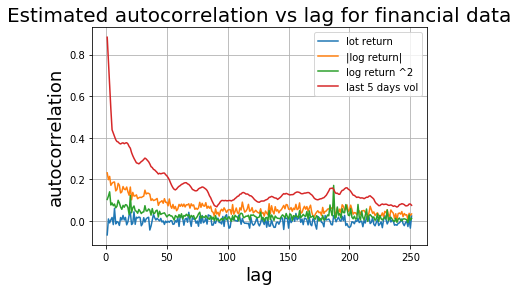

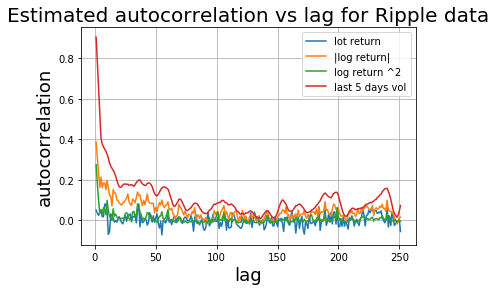

In [24]:
print(stationarity_tests(logR['price']))
print(stationarity_tests(logRR))
plot_autocorrelations(logR['price'], title='financial data')
plot_autocorrelations(logRR, title='Ripple data')

In [25]:
#vol has especially long memory even after a year. The way construct vol here is last 5 days std. But even
#after a year the aucocorrelation is still significant

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


posi start: 0.01337249824580411, posiAlpha: 2.823658256163278
Nega start: 0.014663946719473131, negaAlpha: 2.2625763941703325


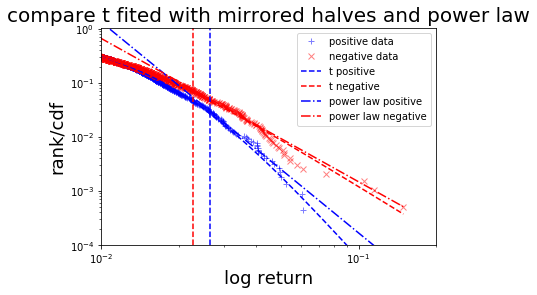

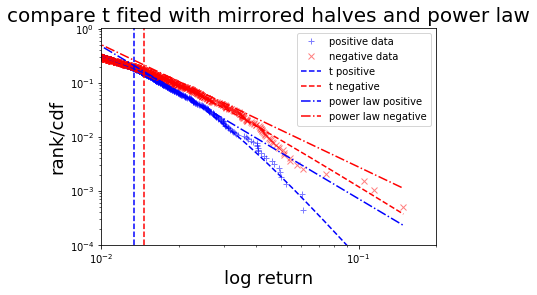

In [26]:
plot_alpha_fitting(logR['price'], stats.t, 93, 117, 3.9, 2.65, 130, 135, adj_start1=0.013, adj_start2=0.008)

In [27]:
#power law how to choose start point  (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906378/)
#The methods find this start point by creating a power law fit starting from each unique value 
#in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance
#between the data and the a fit. 

#When fitting alpha, it does a linear regression. The alpha it return is actually alpha+1 by our
#definition so if use, need to subtract 1

#I selected some alpha and start points myself and plotted them together with t distribution fitted with
#mirrored data. Alpha is greater than 2 which means the attractor is a nomal distribution

#Looking at these two fitting, I cannot say t distribution is constently better, but at least for the
#positive tail
#it look more like a t distribution rather than a power law decay. However, the tail we can see is just a
#sample and the real distribution is unknow. To be conservative when fitting alpha, I rather miss some
#point in the middle than miss the points at the very end of the tail


Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


posi start: 0.16911724155234698, posiAlpha: 2.184406027414581
Nega start: 0.08580472779085824, negaAlpha: 2.1343733994376914


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


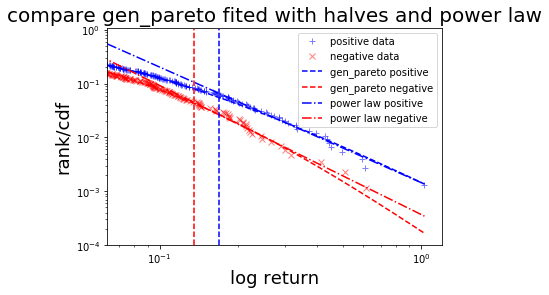

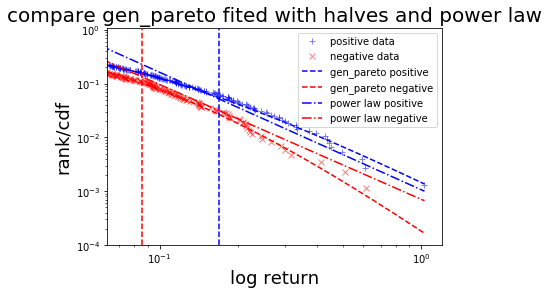

In [28]:
plot_alpha_fitting(logRR, stats.genpareto, 21, 27, 2.15, 2.4, 23, 30, adj_start2=0.05)

In [29]:
#same for ripple, cannot say power law fit better than the gen_pareto and alpha is higher than 2. Both 
#alpha are lower than those for financial data indicating fatter tails but still higher than 2 
#Ripple's positive tail is fatter than negative tail, this is opposite to financial data

In [30]:
#These alphas should be the proper ones to use for scale the tails

In [31]:
weeklyF = resample(logR['price'], 5)
print(len(weeklyF))
monthlyF = resample(logR['price'], 21)
print(len(monthlyF))
weeklyR = resample(logRR, 7)
print(len(weeklyR))
threeDR = resample(logRR, 3)
len(threeDR)

839
199
231


539

In [32]:
#%matplotlib tk

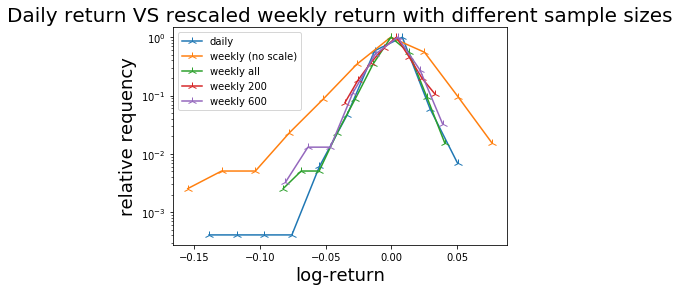

In [32]:
hist, bins = get_histo_data(logR['price'], 10)
histW1, binW1 = get_histo_data(weeklyF[:200], 8)
histW3, binW3 = get_histo_data(weeklyF[:600], 8)
histW, binW = get_histo_data(weeklyF, 10)
mean_a = 0.5 * (2.823658256163278+2.2625763941703325)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, mean_a)
binW1S, histW1S = uni_scale_with_alpha(binW1, histW1, 5, mean_a)
binW3S, histW3S = uni_scale_with_alpha(binW3, histW3, 5, mean_a)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binWS, histWS, '-2', binW1S, histW1S, '-2', binW3S, histW3S, '-2', markersize=9)
plt.title('Daily return VS rescaled weekly return with different sample sizes', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly (no scale)', 'weekly all', 'weekly 200', 'weekly 600'])


In [33]:
#Here we can see central limit theory taking affect when the sample size become larger
#This, from a side angle, indicated that alpha=2 may not be a good scaling factor even if the distribution
#has finite variance and alpha > 2, it also depends on sample size

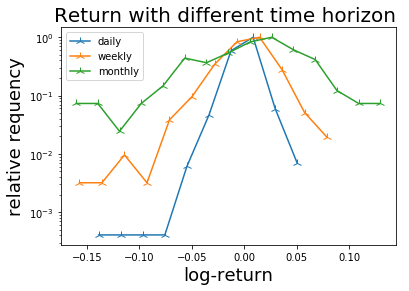

In [34]:
plot_rescale(logR['price'], weeklyF, monthlyF, days1=1, days2=1, alpha=1)

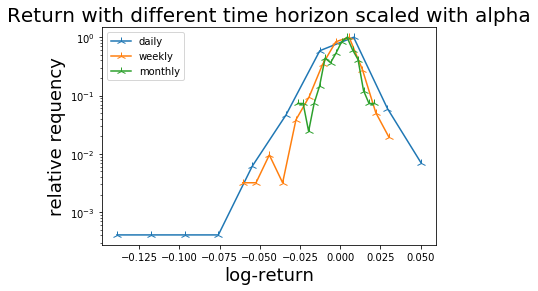

In [35]:
alpha, _, _, _, _ = fit_levy(logR['price'])
plot_rescale(logR['price'], weeklyF, monthlyF, days1=5, days2=21, alpha=alpha, title='scaled with alpha')

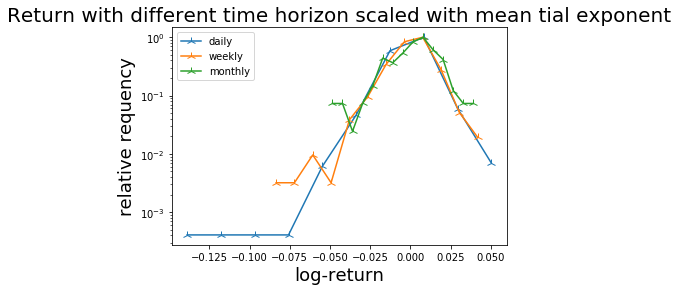

In [36]:
mean_a = 0.5 * (2.823658256163278+2.2625763941703325)
plot_rescale(logR['price'], weeklyF, monthlyF, days1=5, days2=21, alpha=mean_a, title='scaled with mean tial exponent')

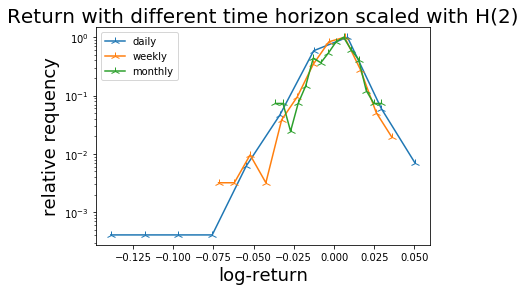

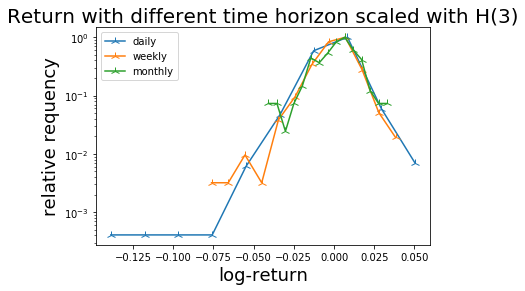

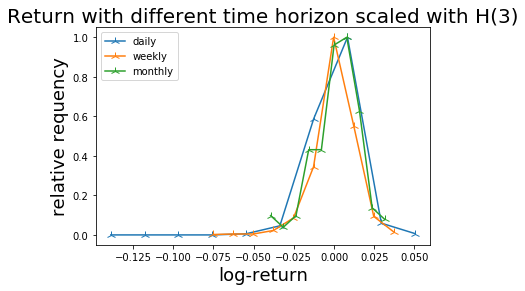

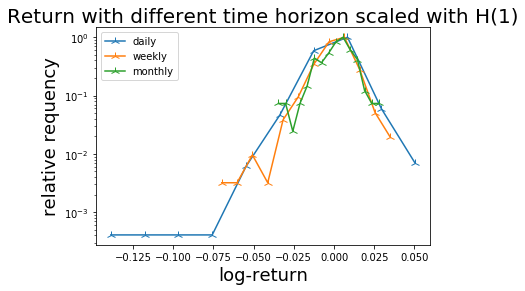

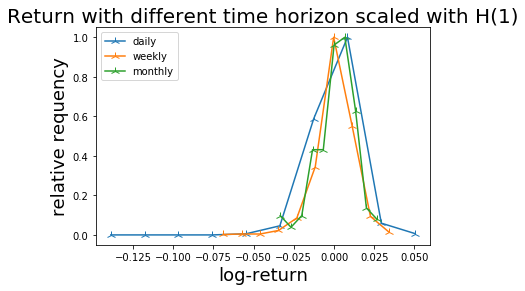

In [37]:
_, b, _ = genHurst(np.cumsum(logR['price']), [1, 2, 3])
plot_rescale(logR['price'], weeklyF, monthlyF, days1=5, days2=21, alpha=1/b[1], title='scaled with H(2)')
plot_rescale(logR['price'], weeklyF, monthlyF, days1=5, days2=21, alpha=1/b[2], title='scaled with H(3)')
plot_rescale(logR['price'], weeklyF, monthlyF, bins1=10, bins2=10, days1=5, days2=21, alpha=1/b[2], title='scaled with H(3)', logScale=False)
plot_rescale(logR['price'], weeklyF, monthlyF, days1=5, days2=21, alpha=1/b[0], title='scaled with H(1)')
plot_rescale(logR['price'], weeklyF, monthlyF, bins1=10, bins2=10, days1=5, days2=21, alpha=1/b[0], title='scaled with H(1)', logScale=False)


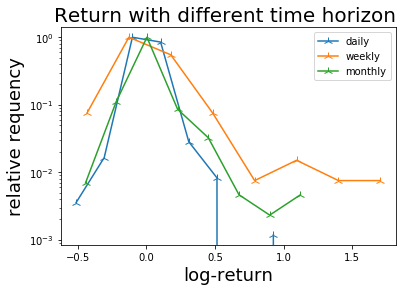

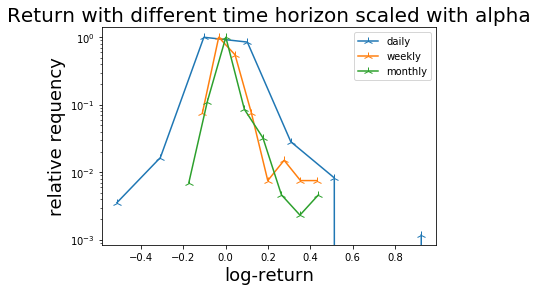

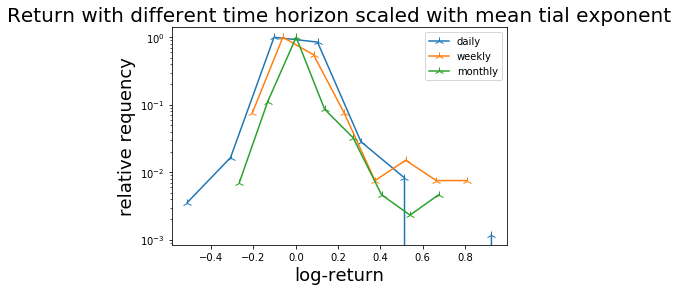

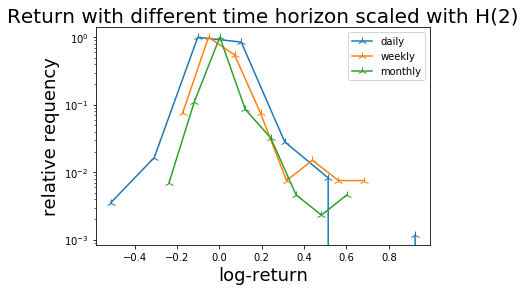

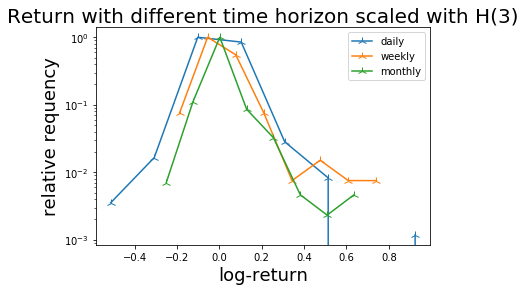

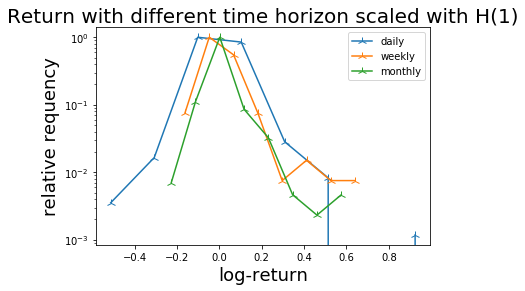

In [33]:
plot_rescale(logRR, weeklyR, threeDR, bins1=, bins0=8, bins2=8, days1=1, days2=1, alpha=1)
alpha, _, _, _, _ = fit_levy(logRR)
plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins0=8, bins2=8, days1=5, days2=3, alpha=alpha, title='scaled with alpha')
mean_a = 0.5 * (2.184406027414581+2.1343733994376914)
plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins0=8, bins2=8, days1=5, days2=3, alpha=mean_a, title='scaled with mean tial exponent')
_, b, _ = genHurst(np.cumsum(logRR), [1, 2, 3])
plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins0=8, bins2=8, days1=5, days2=3, alpha=1/b[1], title='scaled with H(2)')
plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins0=8, bins2=8, days1=5, days2=3, alpha=1/b[2], title='scaled with H(3)')
#plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins2=8, days1=5, days2=3, alpha=1/b[2], title='scaled with H(3)', logScale=False)
plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins0=8, bins2=8, days1=5, days2=3, alpha=1/b[0], title='scaled with H(1)')
#plot_rescale(logRR, weeklyR, threeDR, bins1=8, bins2=8, days1=5, days2=3, alpha=1/b[0], title='scaled with H(1)', logScale=False)


In [39]:
#Here the dataset is sclaed with a few choice: alpha, mean tail exponent, H(1), H(2), H(3)
#Since in this plot, tail has higher resolution, the inprovment on the tail scaling is obvious
#H(1) to H(3) is inproving, mean tail exponent is not bad. Stable is bad

In [40]:
#In either case, stable alpha scaled badly. Log return has auto correlation only for small lags, main
#validation to the assumption is stable distribution, I guess. Cannot confirm since python don't do it...

In [41]:
mean_a = 0.5 * (2.823658256163278+2.2625763941703325)
get_and_scale_moments(logR['price'], 5, np.ones(3) * mean_a)
get_and_scale_moments(weeklyF, scale=False)

0.0002673845240481597|0.00014592963308934022|-1.9091427216812296e-06|0.008468806264022428|
0.0005034820472014566|0.0005174149049589775|-1.2746224486461234e-05|0.015946666810060194|
0.0013289286544985025|0.0006618776548626317|-1.303258027331325e-05|0.01868126968247619|


In [42]:
_, b, _ = genHurst(np.cumsum(logR['price']), [1, 2, 3])
print(b)
get_and_scale_moments(logR['price'], 5, 1/b)
get_and_scale_moments(weeklyF, scale=False)

[0.50418831 0.48690206 0.45014613]
0.0002673845240481597|0.00014592963308934022|-1.9091427216812296e-06|0.008468806264022428|
0.0006019338529972284|0.00069952519544989|-1.6778545992164855e-05|0.0185418102930501|
0.0013289286544985025|0.0006618776548626317|-1.303258027331325e-05|0.01868126968247619|


In [43]:
_, b, _ = genHurst(np.cumsum(logRR), [1, 2, 3])
print(b)
get_and_scale_moments(logRR, 7, 1/b)
get_and_scale_moments(weeklyR, scale=False)

[0.60751944 0.56627377 0.51712658]
0.0037305437508001263|0.006407085669118283|0.0011865222735932628|0.04299509733931216|
0.012167059410690791|0.05804625860514434|0.024285321999613457|0.1294123689408179|
0.027505342633529262|0.06464198946732576|0.055863041285997735|0.14271930948488487|


In [44]:
mean_a = 0.5 * (2.184406027414581+2.1343733994376914)

get_and_scale_moments(logRR, 7, np.ones(3) * mean_a)
get_and_scale_moments(weeklyR, scale=False)

0.0037305437508001263|0.006407085669118283|0.0011865222735932628|0.04299509733931216|
0.009186113456581452|0.03884900192511027|0.017715560499425877|0.10587138728797224|
0.027505342633529262|0.06464198946732576|0.055863041285997735|0.14271930948488487|


In [45]:
#In general, Both scale better with H(n)

In [46]:
def fit_gama_for_auto(data, gama, cons, adj_start):
    max_lag = 800
    autoLogR = abs(pd.Series([data.autocorr(lag=_) for _ in range(1,max_lag)]))
    domain = np.asarray(range(1, max_lag)) * 1.0

    auto_lag = pd.DataFrame()
    auto_lag['auto'] = autoLogR
    auto_lag['lag'] = domain
    plt.plot(auto_lag['lag'], auto_lag['auto'], '+b', alpha = 0.5)
    plt.plot(auto_lag['lag'], cons*auto_lag['lag']**(-gama), alpha=0.4)
    plt.ylim([0, 1])
    
    auto_lag.sort_values('auto', inplace=True)
    plt.figure()
    plt.loglog(auto_lag['lag'], auto_lag['auto'], '+b', alpha = 0.5)
    plt.loglog(auto_lag['lag'], cons*auto_lag['lag']**(-gama), '2', alpha=0.4)
    
    plt.title('fit gama to auto_correlation decay', fontsize=20)
    plt.legend(['auto-correlation', 'power law decay'])
    plt.ylim([0, 1])
    plt.xlim([600, 800])
    
    plt.xlabel('lag of auto-correlation', fontsize=18)
    plt.ylabel('|auto-correlation|', fontsize=18)
    
    fit = powerlaw.Fit(auto_lag['auto'])
    alpha_expo = fit.power_law.alpha
    print(f'alpha = {alpha_expo}')
    start_x = fit.xmin
    print(f'start = {start_x}')
    fit.power_law.plot_ccdf()
    fit.plot_ccdf()

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha = 3.059976543571551
start = 0.10400461504162063


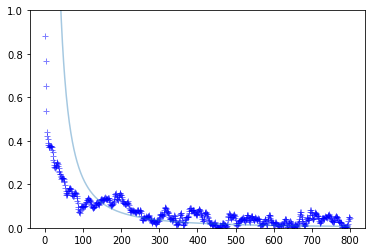

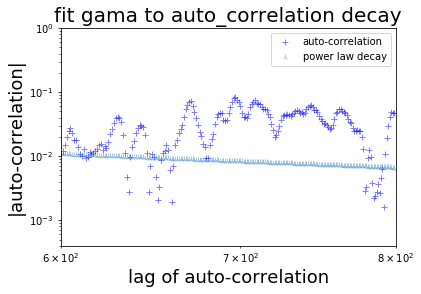

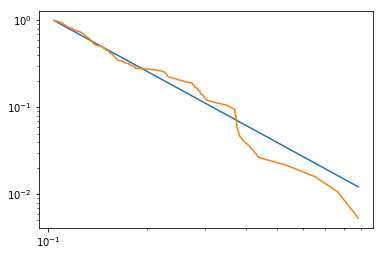

In [47]:
#%matplotlib tk
localVols = pd.Series(get_local_vol(logR['price'], 5))
fit_gama_for_auto(localVols, 1.7, 570, 0)

In [48]:
alpha, beta, loc, scale, likelyhood  = fit_levy(logR['price'])

In [49]:
staSample = levy.random(alpha=alpha, beta=beta, mu=loc, sigma=scale, shape=(5000, 1), par=1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 6.000e+00,
        1.200e+01, 1.800e+01, 4.400e+01, 1.200e+02, 3.800e+02, 8.390e+02,
        1.339e+03, 1.250e+03, 6.390e+02, 1.970e+02, 6.800e+01, 2.200e+01,
        1.100e+01, 1.000e+01, 9.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

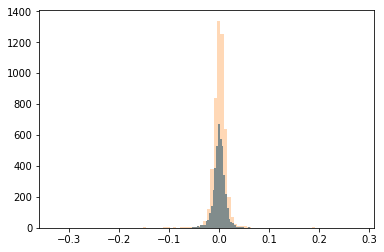

In [50]:
plt.hist(logR['price'], 60, alpha=0.8)
plt.hist(staSample, 90, alpha=0.3)

In [51]:
#This function is from github
#https://github.com/josemiotto/pylevy/blob/master/test.py
"""
The idea of this file is to be able to test the accuracy of the fit.
n_iter sets of size n_data are generated with a Levy distribution of
parameters alpha, beta, mu, sigma.
The 50%, 5% and 95% quantiles of the distributions of the 4 parameters
are returned.
"""
def test_levy(data):
    import levy
    import numpy as np
    from builtins import range
    # from matplotlib import pyplot


    def get_quantiles(l):
        n = float(len(l))
        return l[int(n * 0.5)], l[int(n * 0.05)], l[int(n * 0.95)]

    alpha = 1.0
    beta = 0.0
    mu = 0.0
    sigma = 1.0

    n_iter = 100
    n_data = 1000

    parameters_list = []
    for _ in range(n_iter):
        data = levy.random(alpha, 0.0, 0.0, 1.0, n_data)
        parameters = levy.fit_levy(data)
        parameters_list.append(parameters)
        if _ % 20 == 0:
            print(_)

    alphas = sorted([_[0] for _ in parameters_list])
    betas = sorted([_[1] for _ in parameters_list])
    mus = sorted([_[2] for _ in parameters_list])
    sigmas = sorted([_[3] for _ in parameters_list])

    print(get_quantiles(alphas))
    print(get_quantiles(betas))
    print(get_quantiles(mus))
    print(get_quantiles(sigmas))


In [52]:
test_levy(logR['price'])

0
20
40
60
80
(0.9897664012008951, 0.9222247346596387, 1.0433256143400513)
(-0.009969120722304818, -0.13168160193127476, 0.15942202208622339)
(-0.0033880261499784135, -0.06760089627644532, 0.07038602023913036)
(0.99135693939986, 0.9259635874327162, 1.0555050068861114)


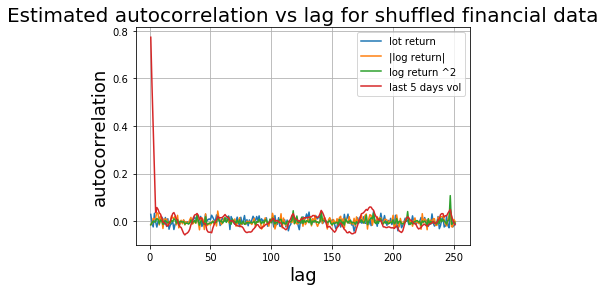

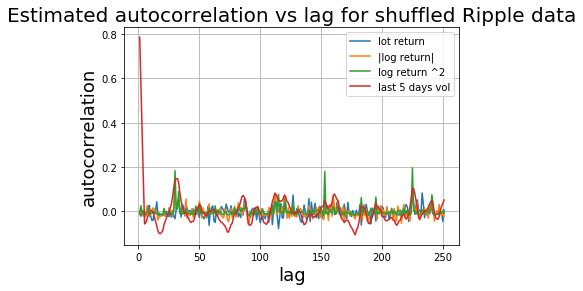

In [53]:
shuLogRF = logR['price'].sample(frac = 1).reset_index(drop = True)
plot_autocorrelations(shuLogRF, title='shuffled financial data')
shuLogRR = logRR.sample(frac = 1).reset_index(drop = True)
plot_autocorrelations(shuLogRR, title='shuffled Ripple data')

'q = 1', 'q = 2', 'q = 3', 'q = 4'


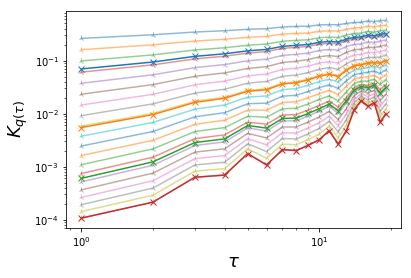

In [54]:
plot_genHurst(np.cumsum(logR['price']), 0.5, 4, 20)

'q = 1', 'q = 2', 'q = 3', 'q = 4'


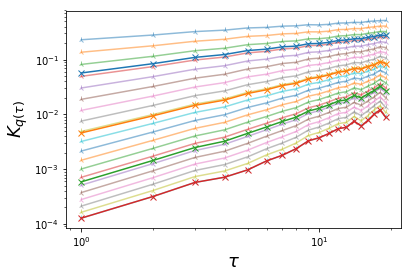

In [55]:
plot_genHurst(np.cumsum(shuLogRF), 0.5, 4, 20)

In [56]:
#shuffled log return, all lines become more straight, WHY? Straignt line still present, so still scaling

'q = 1', 'q = 2', 'q = 3', 'q = 4'


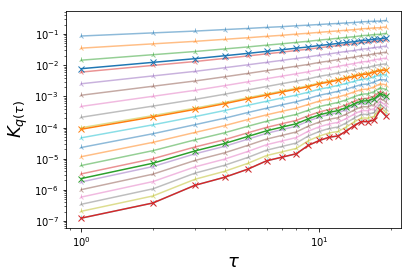

In [57]:
plot_genHurst(np.cumsum(abs(logR['price'])), 0.5, 4, 20)

'q = 1', 'q = 2', 'q = 3', 'q = 4'


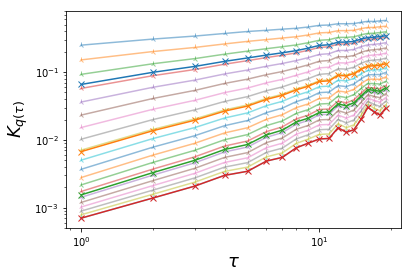

In [58]:
plot_genHurst(np.cumsum(abs(shuLogRF)), 0.5, 4, 20)

In [59]:
#this one become more wiggley after shuffled The line after shuffled also squiesed together

'q = 1', 'q = 2', 'q = 3', 'q = 4'


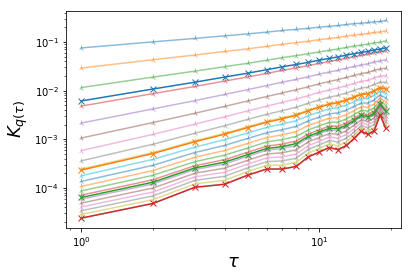

In [60]:
plot_genHurst(np.cumsum(logR['price'] ** 2), 0.5, 4, 20)

'q = 1', 'q = 2', 'q = 3', 'q = 4'


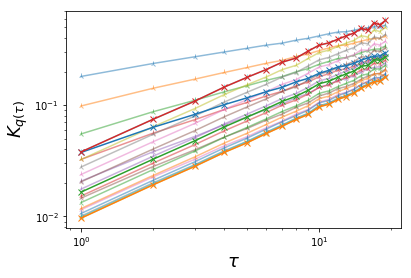

In [61]:
plot_genHurst(np.cumsum(shuLogRF ** 2), 0.5, 4, 20)

In [62]:
#Why after shuffling they all squeised together? log return is a small number and higher order power is
#smaller? But K is nomallized with x^q

'q = 1', 'q = 2', 'q = 3', 'q = 4'


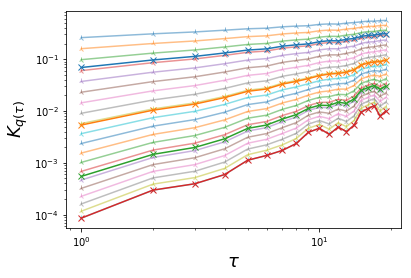

In [63]:
plot_genHurst(my_data['price'], 0.5, 4, 20)

'q = 1', 'q = 2', 'q = 3', 'q = 4'


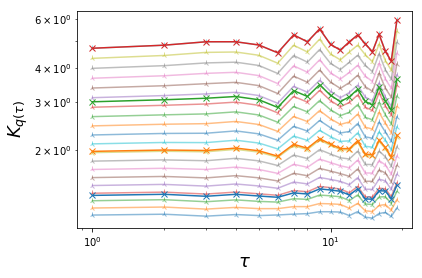

In [64]:
shuPriceF = my_data['price'].sample(frac = 1).reset_index(drop = True)
plot_genHurst(shuPriceF, 0.5, 4, 20)

In [65]:
#This one when the auto correlation is destroied, scaling changed a lot. This is not detrended, and far
#far away from stationary

'q = 1', 'q = 2', 'q = 3', 'q = 4'
'q = 1', 'q = 2', 'q = 3', 'q = 4'
'q = 1', 'q = 2', 'q = 3', 'q = 4'
'q = 1', 'q = 2', 'q = 3', 'q = 4'
'q = 1', 'q = 2', 'q = 3', 'q = 4'
'q = 1', 'q = 2', 'q = 3', 'q = 4'


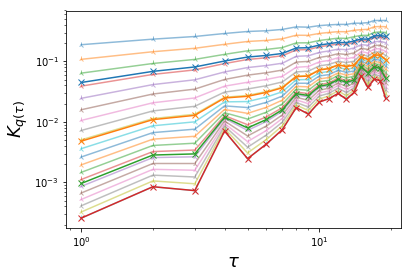

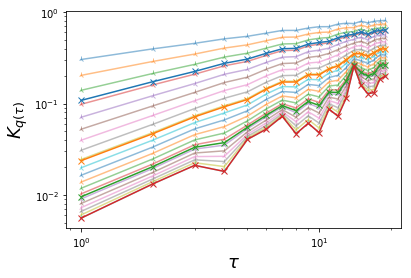

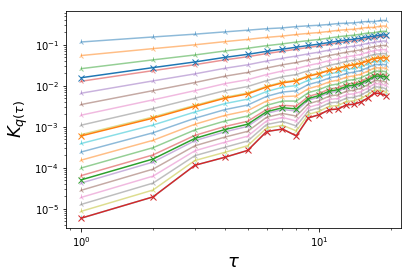

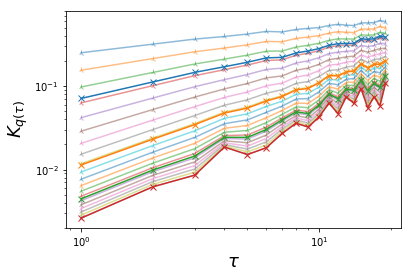

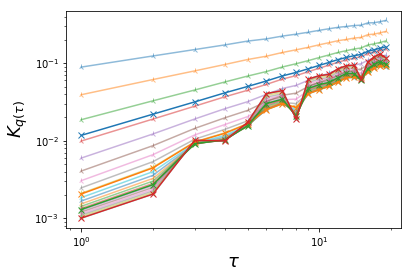

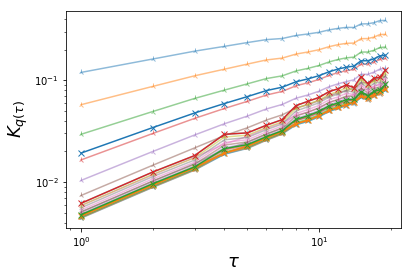

In [66]:
plot_genHurst(np.cumsum(logRR), 0.5, 4, 20)
plot_genHurst(np.cumsum(shuLogRR), 0.5, 4, 20)
plot_genHurst(np.cumsum(abs(logRR)), 0.5, 4, 20)
plot_genHurst(np.cumsum(abs(shuLogRR)), 0.5, 4, 20)
plot_genHurst(np.cumsum(logRR ** 2), 0.5, 4, 20)
plot_genHurst(np.cumsum(shuLogRR ** 2), 0.5, 4, 20)

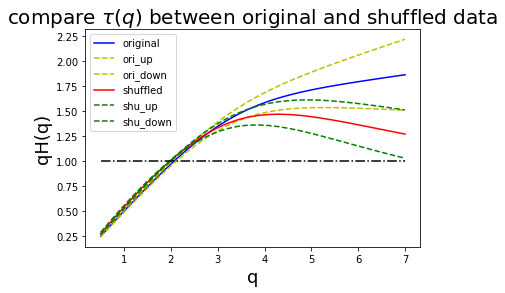

In [67]:
compare_plot_tauQ_vs_q(logR['price'], shuLogRF, 0.5, 7, 30)

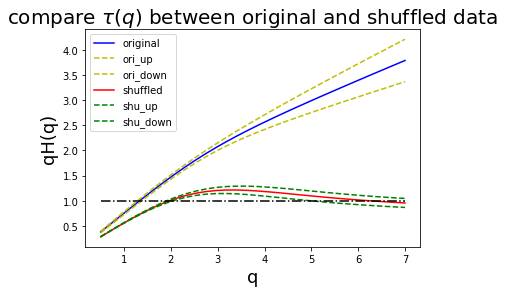

In [68]:
compare_plot_tauQ_vs_q(abs(logR['price']), abs(shuLogRF), 0.5, 7, 30)

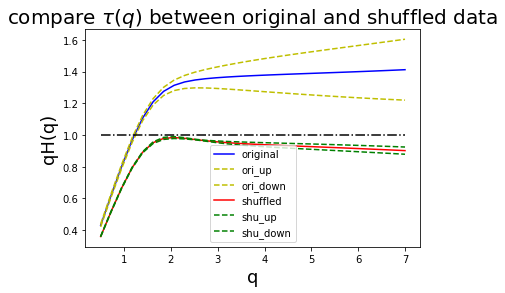

In [69]:
compare_plot_tauQ_vs_q(logR['price']**2, shuLogRF**2, 0.5, 7, 30)

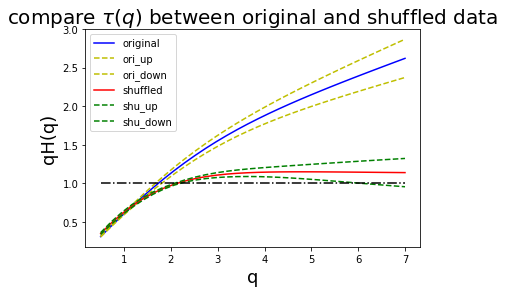

In [70]:
compare_plot_tauQ_vs_q(logRR, shuLogRR, 0.5, 7, 30)

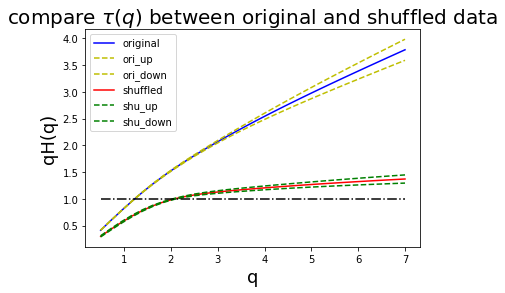

In [71]:
compare_plot_tauQ_vs_q(abs(logRR), abs(shuLogRR), 0.5, 7, 30)

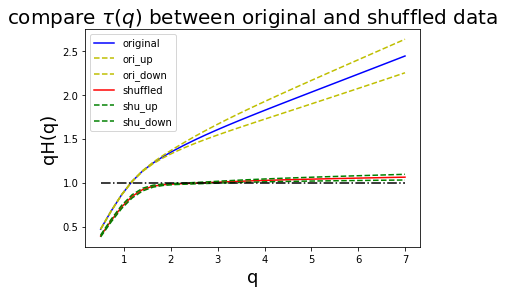

In [72]:
compare_plot_tauQ_vs_q(logRR**2, shuLogRR**2, 0.5, 7, 30)

In [73]:
#in all cases shuffleing really reduced the standard diviation for the H(n)

In [74]:
delta_H(logR['price'], shuLogRF, 1, 3)

original: H(1) - H(3) = 0.054042175432785444
shuffled: H(1) - H(3) = 0.0986776261958548


In [75]:
delta_H(abs(logR['price']), abs(shuLogRF), 1, 3)

original: H(1) - H(3) = 0.0605238991216106
shuffled: H(1) - H(3) = 0.15720902353757882


In [76]:
delta_H(logR['price']**2, shuLogRF**2, 1, 3)

original: H(1) - H(3) = 0.3873346513130996
shuffled: H(1) - H(3) = 0.37814826511902827


In [77]:
delta_H(logRR, shuLogRR, 1, 3)

original: H(1) - H(3) = 0.09039286622051912
shuffled: H(1) - H(3) = 0.26034882583066216


In [78]:
delta_H(abs(logRR), abs(shuLogRR), 1, 3)

original: H(1) - H(3) = 0.13524621696759254
shuffled: H(1) - H(3) = 0.21431825804028515


In [79]:
delta_H(logRR**2, shuLogRR**2, 1, 3)

original: H(1) - H(3) = 0.3659030698908535
shuffled: H(1) - H(3) = 0.4196991571831243


In [80]:
#An apparent increase in multifractality  Overall we conclude that the multifractality observed in
#financial time series is mainly a consequence of the characteristic fat-tail distribution of the returns
#and time-correlations have the effect to decrease the meansured multifractality 
#Understanding the source of multifractality in financial markets

In [81]:
print_H(logR['price'], shuLogRF, 1, 4)
print_H(abs(logR['price']), abs(shuLogRF), 1, 4)
print_H(logR['price']**2, shuLogRF**2, 1, 4)
print_H(logRR, shuLogRR, 1, 4)
print_H(abs(logRR), abs(shuLogRR), 1, 4)
print_H(logRR**2, shuLogRR**2, 1, 4)

original: [0.50418831 0.48690206 0.45014613 0.39655591]
shuffled: [0.5440638  0.5057348  0.44538617 0.36641025]
original: [0.7524245  0.73511754 0.6919006  0.64037566]
shuffled: [0.55853383 0.50454556 0.40132481 0.29552788]
original: [0.84121268 0.65193055 0.45387803 0.34437805]
shuffled: [0.69693056 0.49179792 0.31878229 0.23463504]
original: [0.60751944 0.56627377 0.51712658 0.4695181 ]
shuffled: [0.62994843 0.48707951 0.3695996  0.28640735]
original: [0.82451364 0.76201764 0.68926743 0.63537016]
shuffled: [0.59036377 0.49146777 0.37604551 0.30122244]
original: [0.90032787 0.67319748 0.5344248  0.45539181]
shuffled: [0.75465061 0.49101879 0.33495145 0.25627269]


In [82]:
rescaledLogR = logR['price'] * 5 ** 0.50418831
rescaledVol = pd.Series(get_local_vol(rescaledLogR, 4))
weeklyFVol = pd.Series(get_local_vol(weeklyF, 4))
print(np.mean(rescaledVol))
print(np.mean(weeklyFVol))

0.019459186858785647
0.018402474580608178


0


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


500
1000
1500
2000
2500
3000
3500


vol1         0.048710
vol2         0.045187
vol3         0.041885
realVol      0.042606
Benchmark    0.042503
dtype: float64

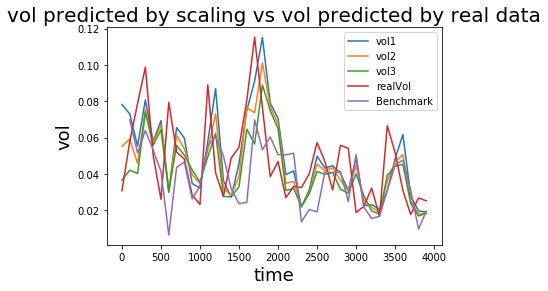

In [83]:
volPrediction = vol_prediction(logR['price'], 6, 21, 120)#look back whole training set and use H of logR
plt.plot(volPrediction[volPrediction.index%100==0])
plt.legend(['vol1', 'vol2', 'vol3', 'realVol', 'Benchmark'])
plt.title('vol predicted by scaling vs vol predicted by real data', fontsize=20)
plt.xlabel('time', fontsize=18)
plt.ylabel('vol', fontsize=18)
np.mean(volPrediction, 0)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
500
1000
1500
2000
2500
3000


vol1         0.087342
vol2         0.078734
vol3         0.070954
realVol      0.092871
Benchmark    0.099663
dtype: float64

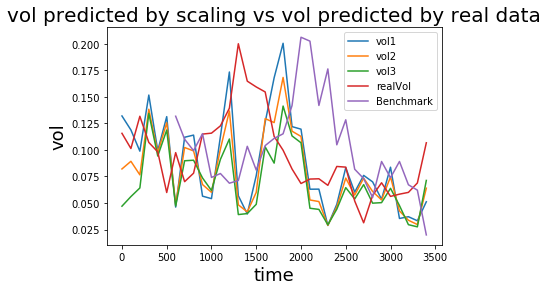

In [84]:
volPrediction = vol_prediction(logR['price'], 10, 63, 120)#count back all training set, using H for (logR)
#%matplotlib tk
plt.plot(volPrediction[volPrediction.index%100==0])
plt.legend(['vol1', 'vol2', 'vol3', 'realVol', 'Benchmark'])
plt.title('vol predicted by scaling vs vol predicted by real data', fontsize=20)
plt.xlabel('time', fontsize=18)
plt.ylabel('vol', fontsize=18)
np.mean(volPrediction, 0)

In [85]:
#the last two blocks, benchmark is the the traditional way of estimation vol. If you need to estimate monthly vol,
#and you define vol is std of next 6 monthly returns, banchmark will be look back 6 * 21 days and find 6 monthly
#returns, calculate the std. In this situation, we can see that the mean of benchmark and mean of vol3 are both 
#close to the real vol. But when we look at the plot, we can see that H adjusted vol prediction seems to adjust
#very fast with the real data. Since vol clusters. When high vol start to show up in the data, if we use the
#traditional method, this information will become a small part of one monthly return. But if we use the scaling 
#method, this information will been kept and really contribute to the std. 
#The second situation is that when you don't have enough data points to do it in the traditional way. In this
#example, calculate in the traditional way need 630 data point, but by scaling method, we only need 120 points.
#Adn again, from the plot, we can see that traditional way has too long a memory and still predict high vol when
#the high vol period has already passed. On the other hand, our scaling method adjust fast and thus gives a better
#prediction using less data points.

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
500
1000


vol1         0.403105
vol2         0.315233
vol3         0.267376
realVol      0.277770
Benchmark    0.287565
dtype: float64

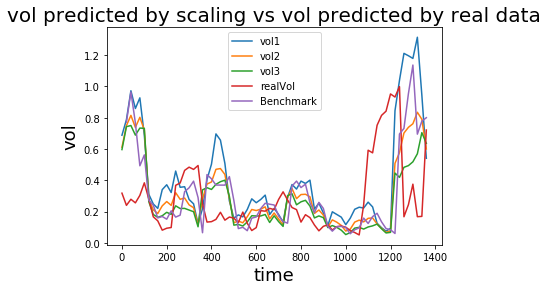

In [86]:
volPrediction = vol_prediction(logRR, 6, 21, 120)#look back whole training set and use H of logR
plt.plot(volPrediction[volPrediction.index%20==0])
plt.legend(['vol1', 'vol2', 'vol3', 'realVol', 'Benchmark'])
plt.title('vol predicted by scaling vs vol predicted by real data', fontsize=20)
plt.xlabel('time', fontsize=18)
plt.ylabel('vol', fontsize=18)
np.mean(volPrediction, 0)

In [87]:
#Doesn't look good...You won't make it into the report I guess

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
500


vol1         0.718749
vol2         0.573058
vol3         0.492486
realVol      0.598109
Benchmark    0.632199
dtype: float64

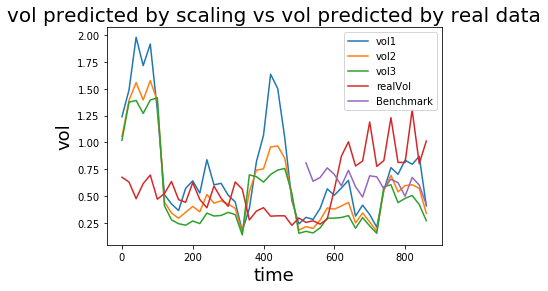

In [88]:
volPrediction = vol_prediction(logRR, 10, 63, 120)#count back all training set, using H for (logR)
plt.plot(volPrediction[volPrediction.index%20==0])
plt.legend(['vol1', 'vol2', 'vol3', 'realVol', 'Benchmark'])
plt.title('vol predicted by scaling vs vol predicted by real data', fontsize=20)
plt.xlabel('time', fontsize=18)
plt.ylabel('vol', fontsize=18)
np.mean(volPrediction, 0)

In [89]:
#Doesn't work for ripple at all...

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


[0.51392161 0.49142687 0.45017372]
3.50460757463394


vol1         0.015811
vol2         0.015249
vol3         0.014270
vol_tail     0.010944
realVol      0.014126
Benchmark    0.014387
dtype: float64

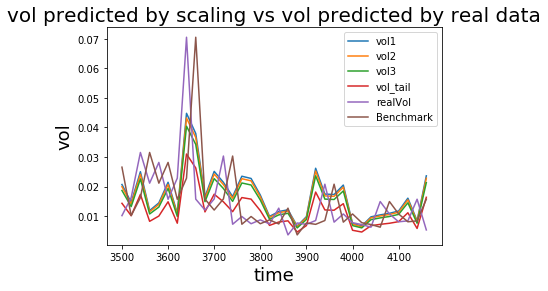

In [90]:
SinvolPrediction = vol_prediction_singleHurst(logR['price'])
plt.plot(SinvolPrediction[SinvolPrediction.index%20==0])
plt.legend(['vol1', 'vol2', 'vol3', 'vol_tail', 'realVol', 'Benchmark'])
plt.title('vol predicted by scaling vs vol predicted by real data', fontsize=20)
plt.xlabel('time', fontsize=18)
plt.ylabel('vol', fontsize=18)
np.mean(SinvolPrediction, 0)

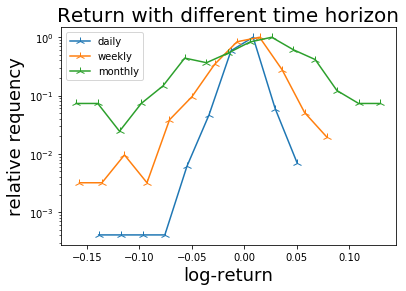

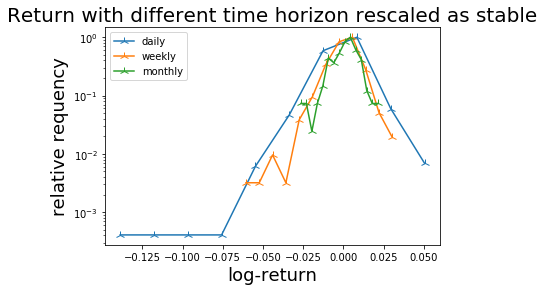

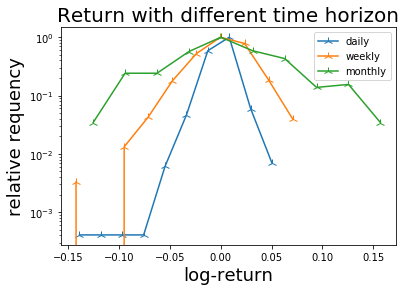

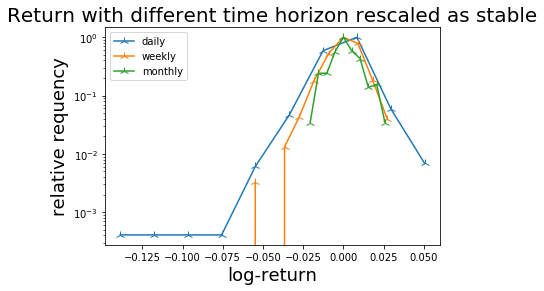

In [91]:

hist, bins = get_histo_data(logR['price'], 10)
histW, binW = get_histo_data(weeklyF, 12)
histM, binM = get_histo_data(monthlyF, 15)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 2)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 2)


alpha, _, _, _, _ = fit_levy(logR['price'])
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 5, alpha)
binMSA, histMSA = uni_scale_with_alpha(binM, histM, 21, alpha)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


plt.figure()
plt.semilogy(bins, hist, '-2', binWSA, histWSA, '-2', binMSA, histMSA, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

weeklyFS = resample(shuLogRF, 5)
monthlyFS = resample(shuLogRF, 21)
hist, bins = get_histo_data(shuLogRF, 10)
histW, binW = get_histo_data(weeklyFS, 10)
histM, binM = get_histo_data(monthlyFS, 10)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 2)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 2)


alpha, _, _, _, _ = fit_levy(shuLogRF)
binWSA, histWSA = uni_scale_with_alpha(binW, histW, 5, alpha)
binMSA, histMSA = uni_scale_with_alpha(binM, histM, 21, alpha)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


plt.figure()
plt.semilogy(bins, hist, '-2', binWSA, histWSA, '-2', binMSA, histMSA, '-2', markersize=9)
plt.title('Return with different time horizon rescaled as stable', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

In [92]:
#Shuffling data and then do genHurst does not make scaling work better, either in this plot or in moments
#forcasting